In [181]:
import os
import glob
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats

from scipy.io import loadmat
import scipy.io
from scipy.fft import fft, fftfreq

import models

In [182]:
class GetData():
    """
    Classe GetData() tem por objetivo extrair informações de um sinal de sensor.

    Parameters
    ----------

    path : string -> caminho onde se encontra o arquivo de sinal do sensor
    filename : string -> nome do arquivo do sinal de interesse
    column : integer -> coluna dentro do arquivo csv onde se encontra o sinal de interesse

    Returns
    -------
    None
    """

    def __init__(self,path,filename,column):
        
        self.path = path
        self.filename = filename
        self.dataset=pd.read_csv(os.path.join(path, self.filename), sep='\t',header=None)

        self.bearing_no = column
        self.bearing_data = np.array(self.dataset.iloc[:,self.bearing_no-1])
    
    def Get(self):
        """
        Get() é um método da Classe GetData()
        que tem por objetivo extrair os dados do sensor de interesse

        Parameters
        ----------

        None

        Returns
        -------
        bearing_data : (N,) Array like -> array coluna contendo o sinal do sensor
        """

        return self.bearing_data

In [183]:
class DominioTempo():
    """
    DominioTempo é uma classe que tem por objetivo extrair indicadores no domínio do tempo

    Parameters
    ----------

    data : array like -> array coluna que representa os dados brutos no domínio do tempo

    Returns
    -------
    None
    """
    def __init__(self,data):
        self.sinal = np.array(data)
        self.length = len(self.sinal)

        self.t_vector = np.linspace(0,1,models.freq_sample)

    def plot_sinal_bruto(self):
        plt.plot(self.t_vector,self.sinal)
        plt.show()

    def maximum(self):
        self.max = np.max(self.sinal)        
        return self.max

    def minimum(self):
        self.min = np.min(self.sinal)        
        return self.min

    def mean(self):
        self.media = np.mean(self.sinal)        
        return self.media

    def standard_deviation(self):
        self.std = np.std(self.sinal, ddof = 1)        
        return self.std

    def rms(self):
        self.rms_value = sqrt(sum(n*n for n in self.sinal)/self.length)        
        return self.rms_value 

    def skewness(self):
        self.n = len(self.sinal)
        self.third_moment = np.sum((self.sinal - np.mean(self.sinal))**3) / self.length
        self.s_3 = np.std(self.sinal, ddof = 1) ** 3
        self.skew = self.third_moment/self.s_3

        return self.skew

    def kurtosis(self):
        self.n = len(self.sinal)
        self.fourth_moment = np.sum((self.sinal - np.mean(self.sinal))**4) / self.n
        self.s_4 = np.std(self.sinal, ddof = 1) ** 4
        self.kurt = self.fourth_moment / self.s_4 - 3

        return self.kurt

    def crest_factor(self):
        self.cf = self.max/self.rms_value
        return self.cf

    def form_factor(self):
        self.ff = self.rms_value/self.media
        return self.ff

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt, freqz, lfilter

import models

class LowPassFilter():
    """
    Classe LowPassFilter() tem por objetivo aplicar um filtro passa-baixa nos dados brutos

    Parameters
    ----------

    data : array like -> array coluna dos dados brutos
    cutoff : float -> frequência de aplicação do filtro
    order : integer -> ordem de aplicação do filtro

    Returns
    -------
    None
    """
    def __init__(self,data, cutoff = models.rpm*(2/60), order = 5):
        self.data = data
        self.cutoff = cutoff
        self.order = order
        self.nyq = models.freq_sample//2

        t_final = len(self.data)/models.freq_sample
        n = int(len(self.data))

        self.vetor_tempo = np.linspace(0,t_final,n)

    def lowpass_filter(self):
        """
        lowpass_filter() é um método que tem por objetivo aplicar o filtro passa-baixa e retornar o valor filtrado.

        Parameters
        ----------

        None

        Returns
        -------
        y : array like -> dados de amplitude filtrada
        """
        normal_cutoff = self.cutoff / self.nyq
        # Get the filter coefficients 
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, self.data)
        return y

    def plot_plotly(self):
        """
        plot_plotly() é um método que exibe os dados filtrados utilizando a biblioteca plotly ao invés do matplotlib

        Parameters
        ----------

        None

        Returns
        -------
        None
        """
        y = self.lowpass_filter()
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = self.data,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = y,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))
        fig.show()
    
    def plot_time_domain(self,plot_raw_data = False):
        """
        plot_time_domain() é um método que tem por objetivo exibir os dados filtrados no domínio do tempo

        Parameters
        ----------

        None

        Returns
        -------
        None
        """
        y = self.lowpass_filter()

        plt.plot(self.vetor_tempo,y)
        if plot_raw_data:
            plt.plot(self.vetor_tempo,self.data)
            plt.legend(['Filtrado','Dados Brutos'])
        plt.show()

In [185]:
import models
import numpy as np
import matplotlib.pyplot as plt
from models import filtro_passa_baixa

class DominioFrequencia():
    """
    Classe DominioFrequencia() tem o objetivo de fazer a análise dos dados no domínio da frequência.

    Parameters
    ----------

    data : (N,) array_like
    rpm : integer
    
    Returns
    -------
    None
    """

    def __init__(self,data,rpm,freq_sample = models.freq_sample):
        
        self.sinal = data # dados brutos
        self.n_points_dado_bruto = len(self.sinal) # npoints
        self.rpm = rpm #rpm
        self.rotacao_hz = self.rpm/60
        self.freq_sample = freq_sample

        duracao_seg = self.n_points_dado_bruto/self.freq_sample # duração em segundos

        self.dt = duracao_seg/self.freq_sample # dt

    def run_fft(self):
        """
        run_fft() é um método da Classe DominioFrequencia() 
        que aplica a fft nos dados de entrada.
        A aplicação da fft segue o seguinte princípio:

        S(f) : transformada de fourier -> a + bi
        S(f)* : transformada de fourier conjugada -> a - bi

        Saída : sqrt(S(f).S(f)*) -> sqrt(a² + b²)

        Parameters
        ----------

        None
        
        Returns
        -------
        None
        """

        # Todo: verificar unidades do dado de entrada e saída da FFT

        # Definindo o valor da amplitude de FFT
        self.fft_transform = np.fft.fft(self.sinal)
        self.fft_transform_conjugado = np.conj(self.fft_transform)

        self.fft_transform = np.sqrt(self.fft_transform*self.fft_transform_conjugado)



        self.fft_frequencia = np.fft.fftfreq(len(self.sinal),d=1/self.freq_sample)

        primeiros_pontos = 2

        self.fft_transform[0:primeiros_pontos] = np.zeros(primeiros_pontos)


        self.fft_frequencia = self.fft_frequencia[0:len(self.fft_frequencia)//2]
        self.fft_transform = self.fft_transform[0:len(self.fft_transform)//2]


    def banda_frequencia(self,freq_referencia,largura = 4):
        """
        banda_de_frequencia() é um método da Classe DominioFrequencia() 
        que tem por objetivo criar uma banda em torno de uma frequência.
        Esta banda tem uma largura definida.

        Parameters
        ----------

        freq_referencia : float -> frequência a qual a janela / banda será centrada
        largura : float -> largura da banda
        
        Returns
        -------
        self.fourier_banda : array_like -> seção da amplitude de fourier referente à banda
        self.frequencia_banda : array_like -: pontos referente à banda
        """
        self.run_fft()

        banda = np.logical_and(self.fft_frequencia >= freq_referencia - largura/2, self.fft_frequencia <= freq_referencia + largura/2)

        self.fourier_banda = self.fft_transform[banda]
        self.frequencia_banda = self.fft_frequencia[banda]

        return self.fourier_banda, self.frequencia_banda

    def plot_banda(self,freq_referencia,largura):

        fourier_banda, frequencia_banda = self.banda_frequencia(freq_referencia,largura)
        plt.figure()
        plt.plot(frequencia_banda, np.abs(fourier_banda))
        plt.ylim((0,1.1*np.max(self.fft_transform)))
        plt.xlabel("Frequência (Hz)")
        plt.ylabel("Amplitude")
        plt.title("Banda de Frequência")
        plt.show()

    def potencia_sinal(self,sinal_fourier):

        fourier_abs = np.abs(sinal_fourier)
        self.potencia = np.sum(fourier_abs**2) / len(fourier_abs)

        return self.potencia

    def plot_potencia_sinal(self,largura):
        self.run_fft()
        for sinal in range(0,len(self.fft_transform),largura):
            potencia = self.potencia_sinal(self.fft_transform[sinal:sinal+largura])
            plt.plot(self.fft_frequencia[sinal:sinal+largura],potencia*np.ones(len(self.fft_frequencia[sinal:sinal+largura])))
        
        plt.title(f'Largura : {largura}')
        plt.show()


    def soma_sinal(self,sinal):
        return np.sum(sinal)
        

In [186]:
class Extrair_indicadores:
    def __init__(self,sinal_bruto,freq_referencia,largura_banda):
        self.sinal = sinal_bruto
        self.freq_referencia = freq_referencia
        self.largura = largura_banda

        self.Objeto_Frequencia = DominioFrequencia(self.sinal,models.rpm,models.freq_sample)
        self.Objeto_Temporal = DominioTempo(self.sinal)

        self.Objeto_Temporal.plot_sinal_bruto()
        
        self.sinal_fourier,self.sinal_frequencia = self.Objeto_Frequencia.banda_frequencia(self.freq_referencia,self.largura)

    def Get(self):
        data_json = {
            'maximum':np.abs(self.Objeto_Temporal.maximum()),
            # 'minimum':np.abs(self.Objeto_Temporal.minimum()),
            # 'mean':np.abs(self.Objeto_Temporal.mean()),
            # 'standard_deviation':np.abs(self.Objeto_Temporal.standard_deviation()),
            'rms':np.abs(self.Objeto_Temporal.rms()),
            'skewness':np.abs(self.Objeto_Temporal.skewness()),
            'kurtosis':np.abs(self.Objeto_Temporal.kurtosis())
            # ,'form_factor':np.abs(self.Objeto_Temporal.form_factor()),
            # 'crest_factor':np.abs(self.Objeto_Temporal.crest_factor())
            ,'potencia':self.Objeto_Frequencia.potencia_sinal(self.sinal_fourier),
            'soma':self.Objeto_Frequencia.soma_sinal(self.sinal_fourier)}

        return data_json
        # return pd.json_normalize(self.data_json)

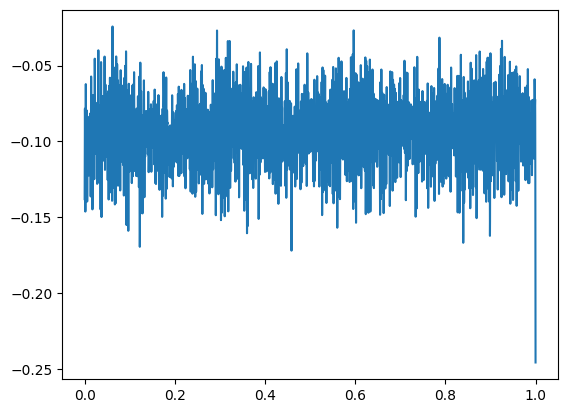

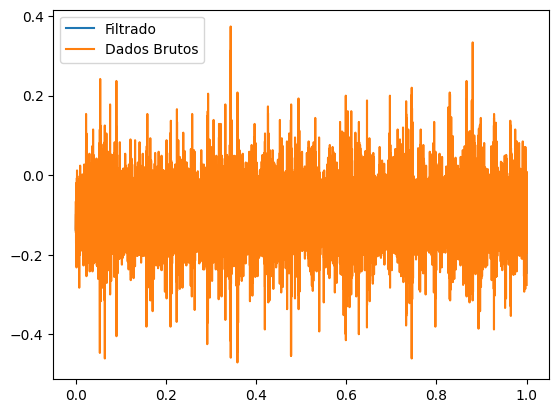

c:\Users\leona\Documents\ProjetoFinal_LeonardoPacheco_UFRJ_LAVI\.venv\lib\site-packages\matplotlib\transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


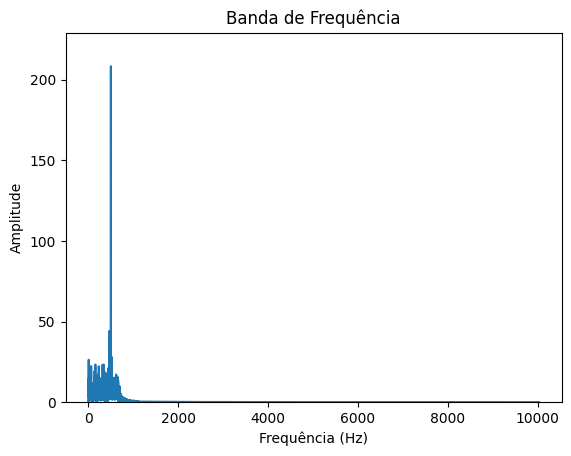

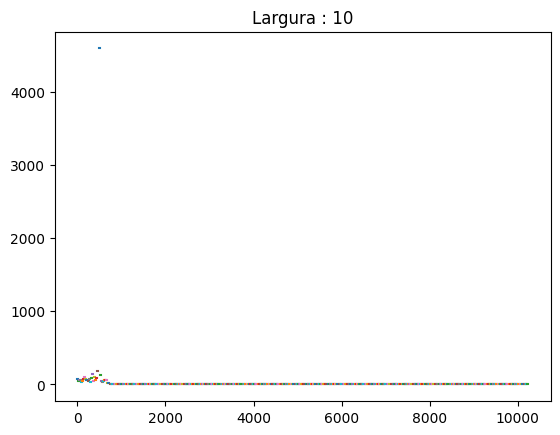

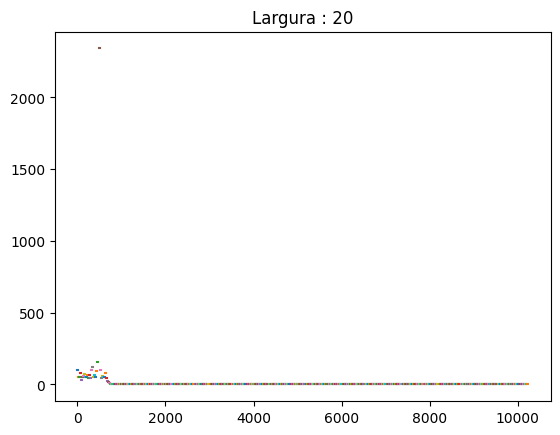

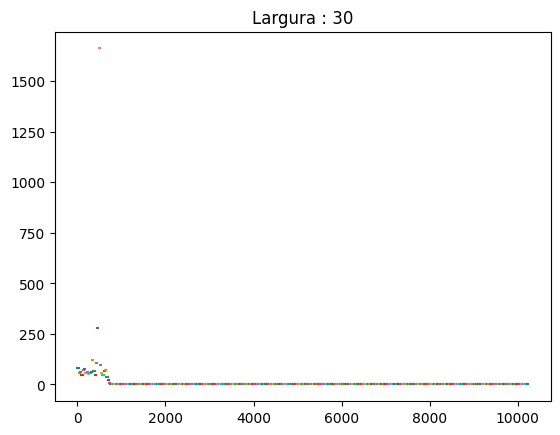

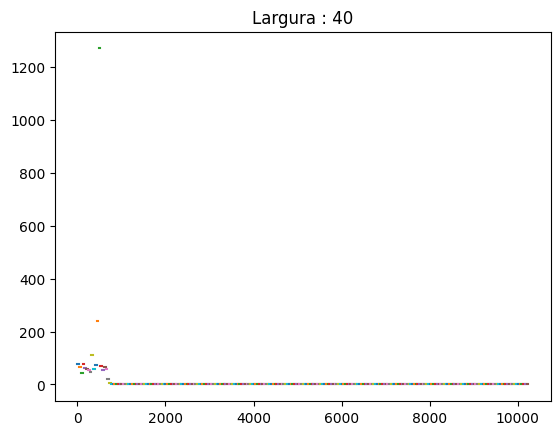

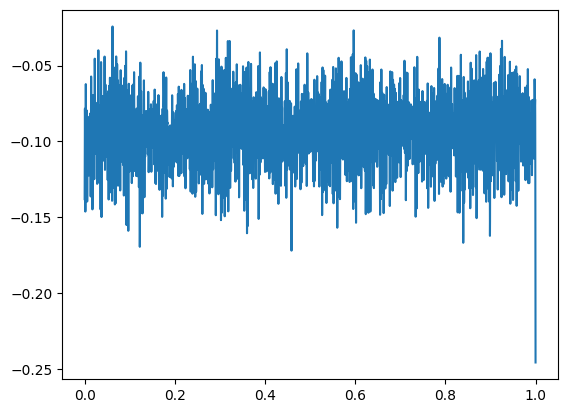

{'maximum': 0.02423587519507012, 'rms': 0.09680354877065868, 'skewness': 0.136614889138805, 'kurtosis': 0.0716544344072858, 'potencia': 2247.3797506552314, 'soma': (448.2593931630488+0j)}


In [187]:
if __name__ == "__main__":

    sinal = GetData(models.PATH_1ST_DATABASE,os.listdir(models.PATH_1ST_DATABASE)[0],0).Get()
    Filtro = LowPassFilter(sinal,cutoff=models.rpm*(20/60))
    Filtro.plot_time_domain(plot_raw_data=False)
    Filtro.plot_time_domain(plot_raw_data=True)
    sinal_filtrado = Filtro.lowpass_filter()

    Teste = DominioFrequencia(sinal_filtrado,models.rpm,models.freq_sample)

    Teste.plot_banda(33,20000)

    # Teste.pegar_indicador(505,5,4)

    # sinal_fourier,sinal_frequencia = Teste.banda_frequencia(505,5)

    # print(Teste.potencia_sinal(sinal_fourier*2))
    for i in range(4):
        Teste.plot_potencia_sinal(10*(i+1))

    teste_extrair = Extrair_indicadores(sinal_filtrado,505,20)

    print(teste_extrair.Get())